In [40]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('./mnist/data/', one_hot = True)

Extracting ./mnist/data/train-images-idx3-ubyte.gz
Extracting ./mnist/data/train-labels-idx1-ubyte.gz
Extracting ./mnist/data/t10k-images-idx3-ubyte.gz
Extracting ./mnist/data/t10k-labels-idx1-ubyte.gz


In [41]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()

In [42]:
faces.images.shape

(13233, 62, 47)

In [43]:
faces.data

array([[  34.        ,   29.33333397,   22.33333397, ...,   14.66666698,
          16.        ,   14.        ],
       [ 158.        ,  160.66667175,  169.66667175, ...,  138.66667175,
         135.33332825,  130.33332825],
       [  77.        ,   81.33333588,   88.        , ...,  192.        ,
         145.33332825,   66.33333588],
       ..., 
       [  38.        ,   41.66666794,   55.33333206, ...,   66.        ,
          63.66666794,   54.33333206],
       [  16.66666603,   24.33333397,   60.33333206, ...,  219.        ,
         143.33332825,   69.33333588],
       [  58.33333206,   48.        ,   20.        , ...,  116.        ,
         106.33333588,  143.33332825]], dtype=float32)

In [44]:
def make_batch(data, labels, batch_size = batch_size):
    total_batch = int(len(data) / batch_size)
    batch_xs = []
    batch_ys = []
    for i in range(total_batch):
        batch_xs.append(data[i * batch_size: (i + 1) * batch_size])
        batch_ys.append(labels[i * batch_size: (i + 1) * batch_size])
    return batch_xs, batch_ys

In [45]:
batch_xs, batch_ys = make_batch(faces.data, faces.target)

In [77]:
tf.reset_default_graph()

# GAN
## 원하는 숫자 생성하기 
- 간단하게 노이즈에 레이블 데이터를 힌트로 넣어주는 방법 사용

In [78]:
total_epoch = 100
batch_size =100
learning_rate = 0.0002
n_hidden = 256
n_input = 62 *47
# 생성자의 입력값으로 사용할 노이즈의 크기
n_noise = 128

In [79]:
X = tf.placeholder(tf.float32, [None, n_input])
Z = tf.placeholder(tf.float32, [None, n_noise])

- 플레이스홀더로 Y를 추가하였는데 결괏값 판정용이 아니고, 노이즈와 실제 이미지에 각각에 해당하는 숫자를 힌트로 넣어주는 용도로 사용한다. 

- 여기서는 고수준 api를 통해 변수를 선언하지 않고 사용한다. 
- 스코프를 지정하여 따로 var_list를 적지않아도 따로 불러올 수있다. 
- tf.concat함수를 이용해 noise 값에 labels 정보를 넣음으로써 힌트를 준다.

In [80]:
def generator(noise):
    with tf.variable_scope('Generator'):
        hidden = tf.layers.dense(noise, n_hidden, activation= tf.nn.relu)
        output = tf.layers.dense(hidden, n_input, activation =tf.nn.sigmoid)
    return output

- 생성자 신경망과 같은 방법으로 구분자 신경망을 만든다.
- 구분자는 진짜 이미지를 판별할 때와 가짜 이미지를 판별할 때 똑같은 변수를 사용해야 한다.
- 그러기 위해서 scope.reuse_variables 함수를 이용해 이전에 사용한 변수들을 재사용하도록 한다.
- cross_entropy를 사용하기 위해 이번에는 output을 선형식으로 사용

In [81]:
def discriminator(inputs, reuse=None):
    with tf.variable_scope('Discriminator') as scope:
        if reuse:
            scope.reuse_variables()
        hidden = tf.layers.dense(inputs, n_hidden, activation= tf.nn.relu)
        output = tf.layers.dense(hidden, n_input, activation = None)
    return output

- 노이즈 생성 유틸함수, 균등분포 사용

In [82]:
def get_noise(batch_size, n_noise):
    return np.random.uniform(-1, 1, [batch_size, n_noise])    

- 생성자를 구성하고 진짜 이미지 데이터와 생성자가 만든 이미지 데이터를 이용하는 구분자를 하나씩 만들어 준다. 
- 이 때 생성자에는 레이블 정보를 추가하여 추후 레이블 정보에 해당하는 이미지를 생성할 수 있도록 유도한다. 
- 가짜 이미지 구분자를 만들 때에는 진짜 이미지 구분자에서 사용한 변수들을 재사용하도록 reuse 옵션을 True로 설정

In [83]:
G = generator(Z)
D_real = discriminator(X)
D_gene = discriminator(G, True)

### 손실 함수
- GAN 논문의 방식과 약간 다른방식 사용
- 출처 : http://bamos.github.io/2016/08/09/deep-completion/
- 진짜 이미지를 판별하는 D_real 값은 1에 가까워지도록,
- 가짜 이미지를 판별하는 D_gene 값은 0에 가까워지도록 하는 것이다
- sigmoid_cross_entropy_with_logits 함수를 이용하여 코드를 더 간편하게 작성
- loss_D는 loss_D_real과 loss_D_gene을 합친 것으로 이 값을 최소화하면 구분자(경찰)을 학습 시킬수 있다. 

In [84]:
# y * log(y) + (1-y) * log(1-y) 니까 
loss_D_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = D_real, labels = tf.ones_like(D_real)))
loss_D_gene = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = D_gene, labels = tf.zeros_like(D_gene)))
loss_D = loss_D_real + loss_D_gene

- D_real은 1에 가까워야하고 (실제 이미지는 진짜라고 판별) D_gene은 0에 가까워야 한다 (생성한 이미지는 가짜라고 판별)
- 이를 위해 loss_D_real은 D_real의 결과값과 D_real의 크기만큼 1로 채운 값(진짜라고 라벨링)들을 비교하고(ones_like 함수)
- loss_D_gene은 D_gene의 결과값과 D_gene의 크기만큼 0으로 채운 값(가짜라고 라벨링)들을 비교한다.(zero_like 함수)


- loss_G는 생성자(위조지폐범)을 학습시키기 위한 함수값
- sigmoid_cross_entropy_with_logits 함수를 이용하여 D_gene을 1에 가깝게 만들기 위해 ones_like함수를 사용한다.

In [85]:
loss_G = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = D_gene, labels = tf.ones_like(D_gene)))

- tf.get_collection함수를 discriminator와 generator 스코프에서 사용된 변수들을 가져온 뒤, 이 변수들을 최적화에 사용할 각각의 손실함수와 함께 최적화 함수에 넣어 학습 모델을 구성한다.

In [86]:
vars_D = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = 'Discriminator')
vars_G = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = 'Generator')

train_D = tf.train.AdamOptimizer().minimize(loss_D, var_list = vars_D)
train_G = tf.train.AdamOptimizer().minimize(loss_G, var_list = vars_G)

In [87]:
faces.images.shape

(13233, 62, 47)

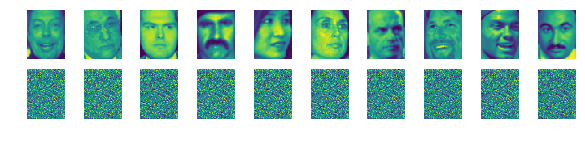

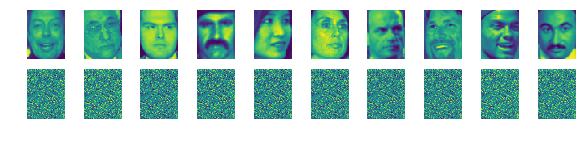

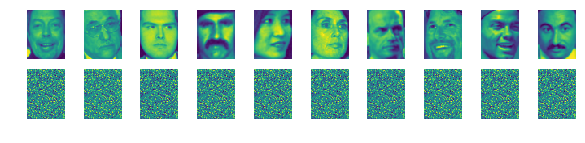

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
total_batch = int(len(faces.data)/batch_size)
loss_val_D, loss_val_G = 0, 0
batch_xs, batch_ys = make_batch(faces.data, faces.target)

for epoch in range(total_epoch):
    for step in range(total_batch):
        
        noise = get_noise(batch_size, n_noise)
        
        _, loss_val_D = sess.run([train_D, loss_D], feed_dict = {X: batch_xs[step], Z: noise})
        _, loss_val_G = sess.run([train_G, loss_G], feed_dict = {Z: noise})
        
    if epoch == 0 or (epoch+1) % 10 == 0:
        sample_size = 10
        noise = get_noise(sample_size, n_noise)
        samples = sess.run(G, feed_dict={Z: noise})
        
        fig, axes = plt.subplots(2, sample_size, figsize=(sample_size, 2))
        
        for i in range(sample_size):
            axes[0][i].set_axis_off()
            axes[0][i].imshow(faces.images[i])
        
            axes[1][i].set_axis_off()
            axes[1][i].imshow(np.reshape(samples[i], (62, 47)))
        plt.show()
        #plt.savefig('./sample/{}.png'.format(str(epoch).zfill(3)), bbox_inches='tight')
        plt.close(fig)
sess.close()